Description des entreprises qui divulguent / ne divulguent pas leurs données de gender pay gap

In [1]:
!pip install openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 15.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import math
import openpyxl


In [3]:
file_imp_path = "data/ESG_raw_data_07_02.xlsx"
file_sect = "data/secteurs.csv"
corresp_secteurs = pd.read_csv(file_sect, sep=";")
imp_data = pd.read_excel(file_imp_path)
imp_data = imp_data.join(corresp_secteurs.set_index('primary_industry'), on = "primary_industry")

In [4]:
data_size = imp_data.shape

print("Size of the DataFrame:")
print("Number of rows:", data_size[0])
print("Number of columns:", data_size[1])

variable_list = imp_data.columns.tolist()
# Display the list of variables
print("List of Variables:")
print(variable_list)

Size of the DataFrame:
Number of rows: 40554
Number of columns: 27
List of Variables:
['company_id', 'year', 'company_name', 'ticker', 'LEI', 'isin', 'Business Desc.', 'region', 'hq_country', 'primary_industry', 'market_cap', 'employees', 'revenue', 'scope_1', 'scope_2', 'scope_3', 'waste_production', 'waste_recycling', 'water_consumption', 'water_withdrawal', 'energy_consumption', 'hours_of_training', 'independent_board_members_percentage', 'legal_costs_paid_for_controversies', 'ceo_compensation', 'gender_pay_gap', 'secteur']


Tableau de stats desc sur nos variables

In [9]:
# Create a table with the % of observations per region 

region_counts = imp_data['region'].value_counts(normalize=True) * 100

# Create a DataFrame from the value counts
region_percentage = pd.DataFrame({'Region': region_counts.index, '% of Observations': region_counts.values})

# Display the DataFrame
print(region_percentage)

                        Region  % of Observations
0               Asia / Pacific          59.890516
1     United States and Canada          19.751443
2                       Europe          13.729842
3         Africa / Middle East           3.491641
4  Latin America and Caribbean           3.136559


In [11]:
# Create a table with the % of observations per country 

region_counts = imp_data['hq_country'].value_counts(normalize=True) * 100

# Create a DataFrame from the value counts
region_percentage = pd.DataFrame({'Pays': region_counts.index, '% of Observations': region_counts.values})

# Display the DataFrame
print(region_percentage)

                    Industrie  % of Observations
0        Industrial Machinery           3.646989
1             Pharmaceuticals           3.092173
2    Packaged Foods and Meats           2.951620
3           Diversified Banks           2.781477
4         Commodity Chemicals           2.633526
..                        ...                ...
149                    Silver           0.059180
150              Retail REITs           0.022193
151              Office REITs           0.014795
152          Industrial REITs           0.014795
153         Diversified REITs           0.014795

[154 rows x 2 columns]


In [13]:
# Create a table with the % of observations per sector 

region_counts = imp_data['secteur'].value_counts(normalize=True) * 100

# Create a DataFrame from the value counts
region_percentage = pd.DataFrame({'Secteur': region_counts.index, '% of Observations': region_counts.values})

# Display the DataFrame
print(region_percentage)

                                       Secteur  % of Observations
0                       Information Technology          12.856931
1                   Industrials, capital goods          12.575825
2                                    Materials          11.577156
3                       Consumer Discretionary          10.948365
4                                   Financials          10.933570
5                                  Health Care           9.720373
6                             Consumer Staples           8.477585
7   Industrials, commercial and transportation           7.663856
8                       Communication Services           4.438526
9                                  Real Estate           3.935493
10                                      Energy           3.484243
11                                   Utilities           3.388075


In [16]:
materials_data = imp_data[imp_data['secteur'] == 'Materials']

# Compter le nombre d'entreprises pour chaque industrie principale
industry_counts = materials_data['primary_industry'].value_counts()

# Afficher les résultats
print("Primary Industry Counts in the Materials Sector:")
print(industry_counts)

Primary Industry Counts in the Materials Sector:
primary_industry
Commodity Chemicals                       1068
Specialty Chemicals                        717
Steel                                      603
Construction Materials                     420
Diversified Metals and Mining              384
Fertilizers and Agricultural Chemicals     345
Gold                                       207
Aluminum                                   171
Paper Products                             156
Metal and Glass Containers                 132
Paper Packaging                            129
Diversified Chemicals                      117
Copper                                      75
Forest Products                             66
Industrial Gases                            42
Precious Metals and Minerals                39
Silver                                      24
Name: count, dtype: int64


In [5]:
imp_data['missing'] = imp_data['gender_pay_gap'].isnull().astype(float)

missing_paygap_subdataset = imp_data[imp_data['missing'] == 1]
non_missing_paygap_subdataset = imp_data[imp_data['missing'] == 0]


data_size = non_missing_paygap_subdataset.shape
#405 observations dans la base non_missing sur 40K 
print("Size of the DataFrame:")
print("Number of rows:", data_size[0])
print("Number of columns:", data_size[1])


Size of the DataFrame:
Number of rows: 405
Number of columns: 28


# Secteurs de prédilection

In [6]:
# Catégorisation en 12 secteurs
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest



# Group by 'secteur' and count occurrences in each dataset
missing_counts = missing_paygap_subdataset['secteur'].value_counts().head(10)
non_missing_counts = non_missing_paygap_subdataset['secteur'].value_counts().head(10)

# Calculate percentages for each dataset
missing_percentages = (missing_counts / missing_counts.sum()) * 100
non_missing_percentages = (non_missing_counts / non_missing_counts.sum()) * 100

# Display the top 10 sectors in each dataset along with their percentages
print("Top 10 Sectors in Missing Pay Gap Subdataset:")
print(missing_counts)

print("\nTop 10 Sectors in Non-Missing Pay Gap Subdataset:")
print(non_missing_counts)

unique_sectors = missing_paygap_subdataset['secteur'].unique()
# Perform Z-tests for each sector
z_test_results = {}
for sector in unique_sectors:
    # Get counts for the current sector in both datasets
    missing_count = missing_paygap_subdataset['secteur'].value_counts()[sector]
    non_missing_count = non_missing_paygap_subdataset['secteur'].value_counts()[sector]
    
    # Total counts in each dataset
    missing_total = len(missing_paygap_subdataset)
    non_missing_total = len(non_missing_paygap_subdataset)
    
    # Perform Z-test
    count = np.array([missing_count, non_missing_count])
    nobs = np.array([missing_total, non_missing_total])
    z_statistic, p_value = proportions_ztest(count, nobs)
    
    # Store results
    z_test_results[sector] = {'z_statistic': z_statistic, 'p_value': p_value}

# Create lists to store significant and nonsignificant sectors
significant_sectors = []
nonsignificant_sectors = []

# Assuming 'z_test_results' is your dictionary containing z-test results for each sector

# Iterate over z-test results
for sector, results in z_test_results.items():
    if results['p_value'] < 0.05:  # Significant at 5% threshold
        significant_sectors.append((sector, results['z_statistic'], results['p_value']))
    else:
        nonsignificant_sectors.append((sector, results['z_statistic'], results['p_value']))

# Create DataFrame for significant sectors
significant_df = pd.DataFrame(significant_sectors, columns=['Sector', 'Z-statistic', 'p-value'])
significant_df['Significance'] = 'Pas de diff signi'

# Create DataFrame for nonsignificant sectors
nonsignificant_df = pd.DataFrame(nonsignificant_sectors, columns=['Sector', 'Z-statistic', 'p-value'])
nonsignificant_df['Significance'] = 'Diff signi'

# Concatenate DataFrames
result_df = pd.concat([significant_df, nonsignificant_df], ignore_index=True)

# Reorder columns
result_df = result_df[[ 'Sector', 'p-value', 'Significance']]

# Display the result in a table
print(result_df)


# Je ne sais pas vraiment si on peut conclure sur une différence notable de "types de secteurs" 
# Peut etre légèrement plus de services dans les ntreprises qui révèlent leur différence de salaire)
# On note cependnant que cette différence n'est pas siginificative pour 4/12 secteurs


Top 10 Sectors in Missing Pay Gap Subdataset:
secteur
Information Technology                        5175
Industrials, capital goods                    5065
Materials                                     4659
Consumer Discretionary                        4394
Financials                                    4392
Health Care                                   3921
Consumer Staples                              3398
Industrials, commercial and transportation    3069
Communication Services                        1767
Real Estate                                   1578
Name: count, dtype: int64

Top 10 Sectors in Non-Missing Pay Gap Subdataset:
secteur
Consumer Discretionary                        46
Financials                                    42
Consumer Staples                              40
Information Technology                        39
Industrials, commercial and transportation    39
Utilities                                     38
Materials                                     36
Industri

 # Biais de taille (seules grosses entreprises divulguent) ?


In [7]:
from scipy.stats import ttest_ind
import statsmodels.api as sm

# Perform independent two-sample t-test for 'employees'
ttest_employees_stat, ttest_employees_pval = ttest_ind(missing_paygap_subdataset['employees'], non_missing_paygap_subdataset['employees'], nan_policy='omit')

# Perform independent two-sample t-test for 'revenue'
ttest_revenue_stat, ttest_revenue_pval = ttest_ind(missing_paygap_subdataset['revenue'], non_missing_paygap_subdataset['revenue'], nan_policy='omit')

# Print results
print("Independent Two-Sample T-test for Employees:")
print("Statistic:", ttest_employees_stat)
print("p-value:", ttest_employees_pval)

print("\nIndependent Two-Sample T-test for Revenue:")
print("Statistic:", ttest_revenue_stat)
print("p-value:", ttest_revenue_pval)


# Différence significative sur les deux aspects mais est ce que cela s'explique par des différences de composition
# sectorielle?

import pandas as pd
from scipy.stats import ttest_ind

# Assuming 'missing_paygap_subdataset' and 'non_missing_paygap_subdataset' are your subdatasets

# Create a function to calculate the mean and perform t-test for each sector
def calculate_sector_statistics(data1, data2, variable):
    sector_statistics = []
    sectors = data1['secteur'].unique()
    for sector in sectors:
        # Subset data for the current sector
        sector_data1 = data1[data1['secteur'] == sector][variable]
        sector_data2 = data2[data2['secteur'] == sector][variable]
        
        # Calculate mean for each database
        mean1 = sector_data1.mean()
        mean2 = sector_data2.mean()
        
        # Perform t-test
        _, p_value = ttest_ind(sector_data1, sector_data2, nan_policy='omit')
        
        # Append results
        sector_statistics.append((sector, mean1, mean2, p_value))
    
    # Create DataFrame
    df = pd.DataFrame(sector_statistics, columns=['Sector', f'{variable}_Mean_Missing', f'{variable}_Mean_Non_Missing', 'p-value'])
    
    return df

# Calculate statistics for 'employees' variable
employees_statistics = calculate_sector_statistics(missing_paygap_subdataset, non_missing_paygap_subdataset, 'employees')

# Calculate statistics for 'revenue' variable
revenue_statistics = calculate_sector_statistics(missing_paygap_subdataset, non_missing_paygap_subdataset, 'revenue')

# Merge statistics for 'employees' and 'revenue' into a single DataFrame
combined_statistics = pd.merge(employees_statistics, revenue_statistics, on='Sector')

# Print the combined statistics
print("Statistics per Sector:")
print(combined_statistics)

# Pas de diff sectorielle, la taille est systématiquement significativement plus elevé dans le cas des non-misisng
# Cela peut peut etre s'expliquer par une legislation plus contraignante sur la divulgation s'appliquant aux grandes
# entreprises



X = sm.add_constant(imp_data[['revenue', 'employees','market_cap']])
y = imp_data['missing']

# Fit logistic regression model
model = sm.OLS(y, X, missing='drop' ).fit()
# Print regression summary
print(model.summary())

# je voulais retrouver un grand R^2 dans la reg d'être missing sur ces deux paramètre de taille
# mais ce n'est pas vraiment le cas -> 0.004
# correlation tout de meme significative et négative entre les deux ( + on est grand (en nb employés notammen) - on divulgue)

Independent Two-Sample T-test for Employees:
Statistic: -8.939555655503472
p-value: 4.107188460805222e-19

Independent Two-Sample T-test for Revenue:
Statistic: -12.495354226784364
p-value: 9.24655422201162e-36
Statistics per Sector:
                                        Sector  employees_Mean_Missing  \
0                       Information Technology            11210.457915   
1                                       Energy            10534.421466   
2                       Communication Services            13146.885734   
3                             Consumer Staples            22132.393372   
4                       Consumer Discretionary            18886.837800   
5                                   Financials            13946.290548   
6                                  Health Care             8258.747093   
7   Industrials, commercial and transportation            15416.456404   
8                   Industrials, capital goods            12550.947952   
9                         

In [8]:
X = imp_data[['revenue', 'employees', 'market_cap', 'region','secteur']]
X = pd.get_dummies(X, columns=['region','secteur'], drop_first=True)
# Convert variables starting with "region" to integers
region_columns = [col for col in X.columns if col.startswith('region') or col.startswith('secteur')]
X[region_columns] = X[region_columns].astype(int)
# Add constant to independent variables
X = sm.add_constant(X)
y = imp_data['missing']

# Fit logisic regression model
model = sm.OLS(y, X,missing ="drop").fit()

# Print regression summary
print(model.summary())

# Gain très marginal de pouvoir predictif en ajoutant région et secteur 


                            OLS Regression Results                            
Dep. Variable:                missing   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     81.23
Date:                Wed, 27 Mar 2024   Prob (F-statistic):          3.71e-293
Time:                        12:02:28   Log-Likelihood:                 26431.
No. Observations:               32695   AIC:                        -5.282e+04
Df Residuals:                   32676   BIC:                        -5.266e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

# Bons/mauvais élèves sur les autres variables d'intérêt en controlant du secteur, de la région, de la taille ?

                            OLS Regression Results                            
Dep. Variable:                missing   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     4.045
Date:                Wed, 27 Mar 2024   Prob (F-statistic):           3.38e-09
Time:                        12:02:28   Log-Likelihood:                -233.67
No. Observations:                1007   AIC:                             511.3
Df Residuals:                     985   BIC:                             619.5
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

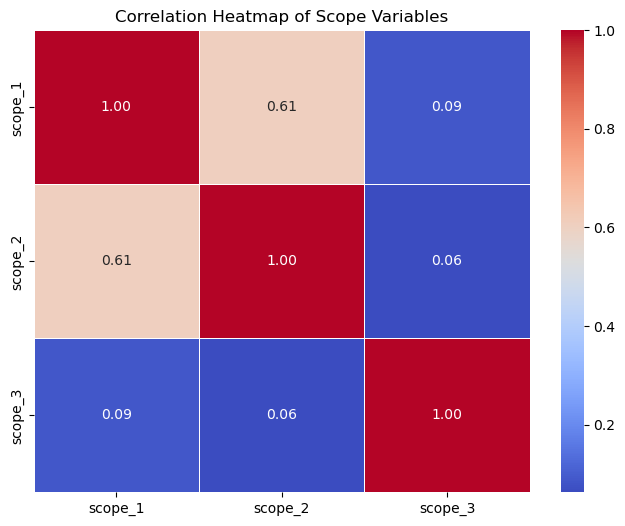

In [9]:
# varia sociales potentiellement reliées : 
# Hours of training per employee 
# ceo compensation

# varia ecolo potentiellement reliées :
# scope 1/2/3



X = imp_data[['hours_of_training','ceo_compensation','scope_1','scope_2',
              'scope_3','revenue', 'employees', 'market_cap','region','secteur']]

"""
log_columns = []
for column in reg_columns:
    # Check if column is numerical and not 'region' or 'secteur'
    if np.issubdtype(imp_data[column].dtype, np.number) and column not in ['region', 'secteur']:
        # Apply logarithmic transformation
        imp_data[column] = np.log(imp_data[column])
        # Add column name to log_columns list
        log_columns.append(column)
"""


# Select relevant columns
# X = imp_data[['region', 'secteur'] + reg_columns]

X = pd.get_dummies(X, columns=['region','secteur'], drop_first=True)
# Convert variables starting with "region" to integers
region_columns = [col for col in X.columns if col.startswith('region') or col.startswith('secteur')]


X[region_columns] = X[region_columns].astype(int)
# Add constant to independent variables
X = sm.add_constant(X)
y = imp_data['missing']

# Fit logisic regression model
model = sm.OLS(y, X,missing ="drop").fit()

# Print regression summary
print(model.summary())

# Scope 3 semble avoir un coefficient proche de la significativité pour expliquer (attention, les scope étant
# potentiellement fortement correlés, peut etre que scope 1 ou 2 expliquent tout autant)

# region_Asia / Pacific  0.2436 / secteur_Consumer Discretionary   0.1079  -> Très grand coef pour region/secteur 
# par rapport à avant, ca parait assez bizarre


scope_columns = ['scope_1', 'scope_2', 'scope_3']

# Calculate the correlation matrix
correlation_matrix = imp_data[scope_columns].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Scope Variables')
plt.show()

# Correlation forte mais pas de 1 entre les 3 scopes !! Fouiller le scope 3

Analyse en composante principales (ACP) pour faire ressortir les principales variables discriminantes de ceux qui ne divulgent pas

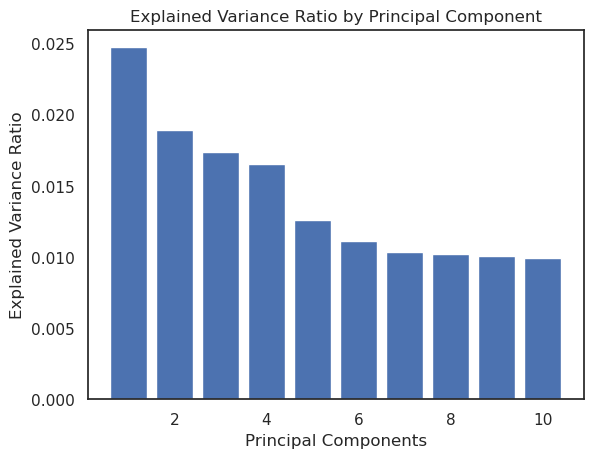

Top 10 Loading Vectors for PC1 (arranged by importance):
                            Variable   Loading  Absolute_Loading
8              region_Asia / Pacific -0.533106          0.533106
11   region_United States and Canada  0.409890          0.409890
110         hq_country_United States  0.386780          0.386780
27                  hq_country_China -0.341738          0.341738
9                      region_Europe  0.224738          0.224738
2                            revenue  0.172349          0.172349
0                         market_cap  0.148070          0.148070
1                          employees  0.143521          0.143521
116               secteur_Financials  0.122273          0.122273
24                 hq_country_Canada  0.109312          0.109312


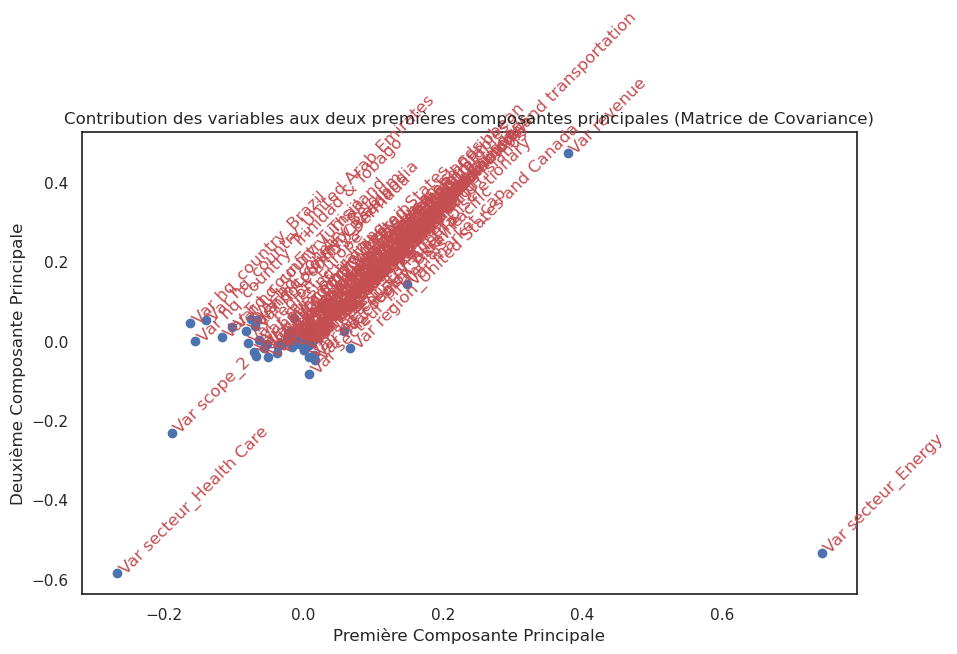

In [64]:
# Importing necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Selecting relevant features for PCA
X = imp_data[['secteur','region', 'hq_country', 'market_cap', 'employees', 'revenue',
                               'scope_1','scope_2', 'scope_3', 
                                'hours_of_training','missing']]

# Converting categorical variables to dummy variables
X = pd.get_dummies(X, columns=['region', 'hq_country', 'secteur'], drop_first=True)

# Ensuring that categorical variables are encoded as integers
region_columns = [col for col in X.columns if col.startswith('region') or col.startswith('secteur')
                 or col.startswith('hq_country')]
X[region_columns] = X[region_columns].astype(int)

# Define columns for which you want to impute missing values with mean
columns_to_impute = ['scope_1', 'scope_2', 'scope_3', 'hours_of_training','market_cap', 'employees', 'revenue']

# Apply imputation for specified columns
imputer = SimpleImputer(strategy='mean')
X[columns_to_impute] = imputer.fit_transform(X[columns_to_impute])

# Apply scaling to the entire DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame
X_transformed = pd.DataFrame(X_scaled, columns=X.columns)

# Dropping rows with missing values
X_transformed.dropna(inplace=True)

# Performing PCA
pca = PCA()
pca.fit(X_transformed)

# Plotting explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
plt.bar(range(1, 11), explained_variance_ratio[:10]) 
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

# Interpreting first principal component
first_pc  = pca.components_[0]

decomposition_first_pc = pd.DataFrame({'Variable': X_transformed.columns, 'Loading': first_pc})
decomposition_first_pc['Absolute_Loading'] = abs(decomposition_first_pc['Loading'])
decomposition_first_pc_sorted = decomposition_first_pc.sort_values(by='Absolute_Loading', ascending=False)
print("Top 10 Loading Vectors for PC1 (arranged by importance):")
print(decomposition_first_pc_sorted.head(10))




# Interpreting first two principal component

composantes_principales = pca.components_
first_pc = composantes_principales[:, 0]
second_pc = composantes_principales[:, 1]
variable_names = X_transformed.columns.tolist()


# Tracer le graphique de dispersion des deux premières composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(first_pc, second_pc)

# Annoter chaque point avec le nom de la variable
for i, variable in enumerate(variable_names):
    plt.annotate(f'Var {variable}', (first_pc[i], second_pc[i]), color='r', rotation=45)

# Ajouter des labels et un titre au graphique
plt.title('Contribution des variables aux deux premières composantes principales (Matrice de Covariance)')
plt.xlabel('Première Composante Principale')
plt.ylabel('Deuxième Composante Principale')

# Afficher le graphique
plt.show()

Le principe est simple : Il s’agit en fait de résumer l’information qui est contenue dans une large base de données en un certain nombre de variables synthétiques appelées : Composantes principales. 


0n retrouve que le market cap/ revenue /nb employés qui sont tous des proxy de la taille de l'entreprise contribuent nettement à expliquer la première composante principale et donc la variance au sein de la base de donnée.

-> Info inutile puisque on cherche plutot à comprendre l'effet des varia sur missing
-> Missing ne joue clairement pas un rôle prépondérant

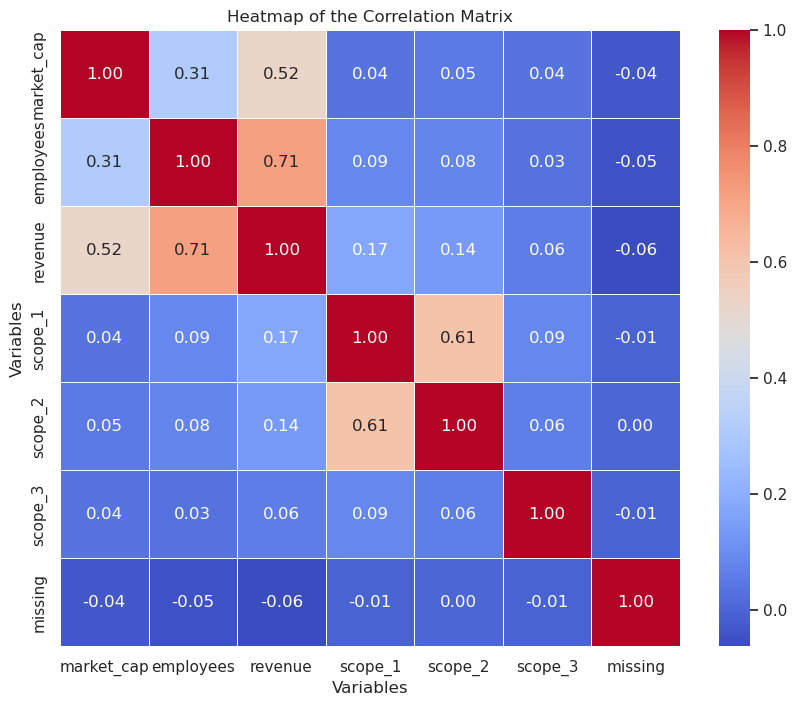

Top 10 Correlated Variables with highest absolute correlation with 'missing':
                         Variable  Correlation with missing  \
0       hq_country_United Kingdom                 -0.218913   
1                   region_Europe                 -0.193395   
2           region_Asia / Pacific                  0.107549   
3                hq_country_Spain                 -0.102673   
4                hq_country_China                  0.066475   
5                         revenue                 -0.062693   
6  water_consumption_per_employee                 -0.060108   
7                       employees                 -0.049331   
8               hq_country_France                 -0.045801   
9             hq_country_Portugal                 -0.041345   

   Absolute Correlation with missing  
0                           0.218913  
1                           0.193395  
2                           0.107549  
3                           0.102673  
4                           0.066

In [79]:
X = imp_data[[ 'market_cap', 'employees', 'revenue',
                               'scope_1','scope_2', 'scope_3', 
                                'missing']]


X = X.astype(float)

# Apply scaling to the entire DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_transformed = pd.DataFrame(X_scaled, columns=X.columns)


# Compute the covariance matrix
corr_matrix = X_transformed.corr()

# Set figure size
plt.figure(figsize=(10, 8))

# Create a heatmap of the covariance matrix
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Set axis labels
plt.xlabel('Variables')
plt.ylabel('Variables')

# Set title
plt.title('Heatmap of the Correlation Matrix')

# Show the plot
plt.show()

# Missing correlé plus fortement à variables de taille qu'à scope

imp_data['waste_production_per_employee'] = imp_data['waste_production'] / imp_data['employees']
imp_data['waste_recycling_per_employee'] = imp_data['waste_recycling'] / imp_data['employees']
imp_data['scope_1_per_employee'] = imp_data['scope_1'] / imp_data['employees']
imp_data['scope_2_per_employee'] = imp_data['scope_2'] / imp_data['employees']
imp_data['scope_3_per_employee'] = imp_data['scope_3'] / imp_data['employees']
imp_data['water_consumption_per_employee'] = imp_data['water_consumption'] / imp_data['employees']
imp_data['water_withdrawal_per_employee'] = imp_data['water_withdrawal'] / imp_data['employees']
imp_data['energy_consumption_per_employee'] = imp_data['energy_consumption'] / imp_data['employees']
imp_data['hours_of_training_per_employee'] = imp_data['hours_of_training'] / imp_data['employees']

X = imp_data[['secteur', 'region', 'hq_country', 'market_cap', 'employees',
 'revenue', 'scope_1_per_employee', 'scope_2_per_employee', 'scope_3_per_employee', 'waste_production_per_employee', 
 'waste_recycling_per_employee', 'water_consumption_per_employee', 'water_withdrawal_per_employee', 
              'energy_consumption_per_employee', 'hours_of_training_per_employee', 
              'independent_board_members_percentage', 'legal_costs_paid_for_controversies',
 'ceo_compensation', 'missing']]


X = pd.get_dummies(X, columns=['region', 'hq_country', 'secteur'], drop_first=True)

# Ensuring that categorical variables are encoded as integers
region_columns = [col for col in X.columns if col.startswith('region') or col.startswith('secteur')
                 or col.startswith('hq_country')]
X[region_columns] = X[region_columns].astype(float)

X = X.astype(float)

# Apply scaling to the entire DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_transformed = pd.DataFrame(X_scaled, columns=X.columns)


# Compute the covariance matrix
corr_matrix = X_transformed.corr()

correlation_with_missing = corr_matrix['missing'].abs().sort_values(ascending=False)

# Select the top 10 correlated variables with highest absolute correlation
top_10_correlated = correlation_with_missing[1:11]  # Exclude 'missing' itself

# Create a DataFrame to hold the top 10 correlated variables with both absolute and non-absolute correlation values
top_10_correlated_df = pd.DataFrame({
    'Variable': top_10_correlated.index,
    'Correlation with missing': corr_matrix['missing'][top_10_correlated.index].values,
    'Absolute Correlation with missing': top_10_correlated.values
})

# Print the DataFrame
print("Top 10 Correlated Variables with highest absolute correlation with 'missing':")
print(top_10_correlated_df)

# Explication taille + localisation Europe/asie sans secteur particulier semble apparaitre
# Plus de divulgation en Europe / - en Asie
# Plus de divulgation quand taille augmente
# Plus de divulgation associé également à water recycling